## Введение

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Задание № 1

In [3]:
def calc_metrics(add_data: str = None, p_value: float = 0.05) -> tuple['pd.DataFrame', 'pd.DataFrame', 'pd.DataFrame']:
    """
    Данная функция рассчитывает статистику по метрикам среднего чека и конверсии.
    
    Параметры
    ---------------
    add_data: str, default None - путь до csv файла с дополнительным распределением пользователей по группам.
    p_value: float, default 0.05 - уровень значимости для статистических тестов.
    
    Возвращает
    ---------------
    Кортеж, где первый элемент - результаты расчетов, второй - данные по чекам, третий - данные по конверсиям.
    """
    
    # Импорты
    import pandas as pd
    from numpy import log
    from scipy.stats import ttest_ind, chi2_contingency
    from functions import get_yd  # Самописная функция - используется для парсинга данных по ссылке Яндекс Диска
    
    # Ссылки на датасеты
    groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
    active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
    checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
    
    # Таблица для будущего аутпута
    results = pd.DataFrame(columns={'metric': 'str',
                                    'in_control': 'float',
                                    'in_test': 'float',
                                    'diff': 'float',
                                    'diff_percent': 'float', 
                                    'stat_test': 'str',
                                    'p-value': 'float',
                                    'is_significant': 'boolean'})
    
    # Подгрузка данных
    groups = pd.read_csv(get_yd(groups_link), sep=';')
    active_studs = pd.read_csv(get_yd(active_studs_link), sep=';')
    checks = pd.read_csv(get_yd(checks_link), sep=';')
    
    # Добавляем новые данные к основному датасету
    if add_data:
        groups_add = pd.read_csv(add_data, sep=',')
        groups['period'] = 'primary'
        groups_add['period'] = 'secondary'
        groups_full = pd.concat([groups, groups_add])
    else:
        groups_full = groups

    # Удаление дубликатов (при этом данные из дополнительного файла считаются более актуальными)
    groups_full = groups_full.drop_duplicates(subset=['id'], keep='last')

    # СРЕДНИЙ ЧЕК----------------------------------------------------------------------------------------------------------
    # Джоин групп и подготовка прологарифмированной выручки
    checks_with_groups = checks.merge(groups_full, how='left', left_on='student_id', right_on='id')
    checks_with_groups['rev_log'] = log(checks_with_groups.rev)
    control_values_log = checks_with_groups.query('grp == "A"').rev_log
    test_values_log = checks_with_groups.query('grp == "B"').rev_log
    
    # Расчет метрики в обеих группах
    avg_check_calc = (checks_with_groups.groupby('grp', as_index=False).rev.mean())
    avg_check_calc_control = round(avg_check_calc.rev[0])
    avg_check_calc_test = round(avg_check_calc.rev[1])

    # Расчет ститистики теста Стьюдента на прологарифмированных данных
    check_ttest_result = ttest_ind(control_values_log, test_values_log)
    check_ttest_pvalue = check_ttest_result[1]

    # Подготовка словаря для аппенда в датафрейм с результатами
    avg_check_result = {'metric': 'average check',
                        'in_control': avg_check_calc_control,
                        'in_test': avg_check_calc_test,
                        'diff': round(avg_check_calc_test - avg_check_calc_control, 2),
                        'diff_percent': str(round((avg_check_calc_test / avg_check_calc_control - 1)  * 100, 1)) + '%', 
                        'stat_test': 'log t-test',
                        'p-value': check_ttest_pvalue,
                        'is_significant': check_ttest_pvalue <= p_value}
    
    results = results.append(avg_check_result, ignore_index=True)
    
    # КОНВЕРСИЯ------------------------------------------------------------------------------------------------------------
    # Подготовка кросс-таблицы
    active_studs_by_groups = (active_studs.merge(groups_full, how='left', left_on='student_id', right_on='id'))
    active_studs_by_groups['conversion'] = (active_studs_by_groups.student_id.isin(checks_with_groups.student_id))
    conversion = pd.crosstab(active_studs_by_groups.grp, active_studs_by_groups.conversion)

    # Расчет метрики в обеих группах
    conversion_calc = (conversion[True] / (conversion[True] + conversion[False]) * 100).round(2)
    conversion_calc_control = conversion_calc[0]
    conversion_calc_test = conversion_calc[1]

    # Расчет статистики Хи-квадрат
    conv_chi2_test = chi2_contingency(conversion)
    conv_chi2_p_value = conv_chi2_test[1]

    # Подготовка словаря для аппенда в датафрейм с результатами
    conv_result = {'metric': 'conversion rate',
                   'in_control': conversion_calc_control,
                   'in_test': conversion_calc_test,
                   'diff': round(conversion_calc_test - conversion_calc_control, 2),
                   'diff_percent': str(round((conversion_calc_test / conversion_calc_control - 1)  * 100, 1)) + '%', 
                   'stat_test': 'chi2',
                   'p-value': conv_chi2_p_value,
                   'is_significant': conv_chi2_p_value <= p_value}
    
    results = results.append(conv_result, ignore_index=True)
    
    return (results, checks_with_groups, active_studs_by_groups)

In [4]:
# Тест функции
from functions import get_yd 
add_data = get_yd('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
results = calc_metrics(add_data)
results[0]

,metric,in_control,in_test,diff,diff_percent,stat_test,p-value,is_significant
0,average check,861,1109,248,28.8%,log t-test,0.000448,True
1,conversion rate,5.07,4.62,-0.45,-8.9%,chi2,0.486252,False


## Задание № 2

In [5]:
def vis_metrics(data: 'pd.DataFrame', metric: 'str') -> None:
    import matplotlib.pyplot as plt
    
    if metric == 'avg_check':
        
        import seaborn as sns
        checks_df = results[1]

        # Создание сетки, заголовка и подписей
        figure, axes = plt.subplots(2, 2, figsize=(20, 8), sharex='col', sharey=False)
        figure.suptitle('Average Check, usd')
        axes[0, 0].set_ylabel('Control Group')
        axes[1, 0].set_ylabel('Test Group')

        # Графики
        sns.histplot(ax=axes[0, 0], data=checks_df.query('grp == "A"'), x='rev', kde=True)
        sns.histplot(ax=axes[1, 0], data=checks_df.query('grp == "B"'), x='rev', kde=True)
        sns.boxplot(ax=axes[0, 1],data=checks_df.query('grp == "A"'), x='rev')
        sns.boxplot(ax=axes[1, 1],data=checks_df.query('grp == "B"'), x='rev')

        plt.show()
    
    elif metric == 'conv_rate':
        from statsmodels.graphics.mosaicplot import mosaic
        convers_df = results[2]
        mosaic(convers_df, ['grp', 'conversion'], gap=0.01)
        plt.suptitle('Conversion Rate')
        plt.show()
    
    else:
        print('Wrong metric.')

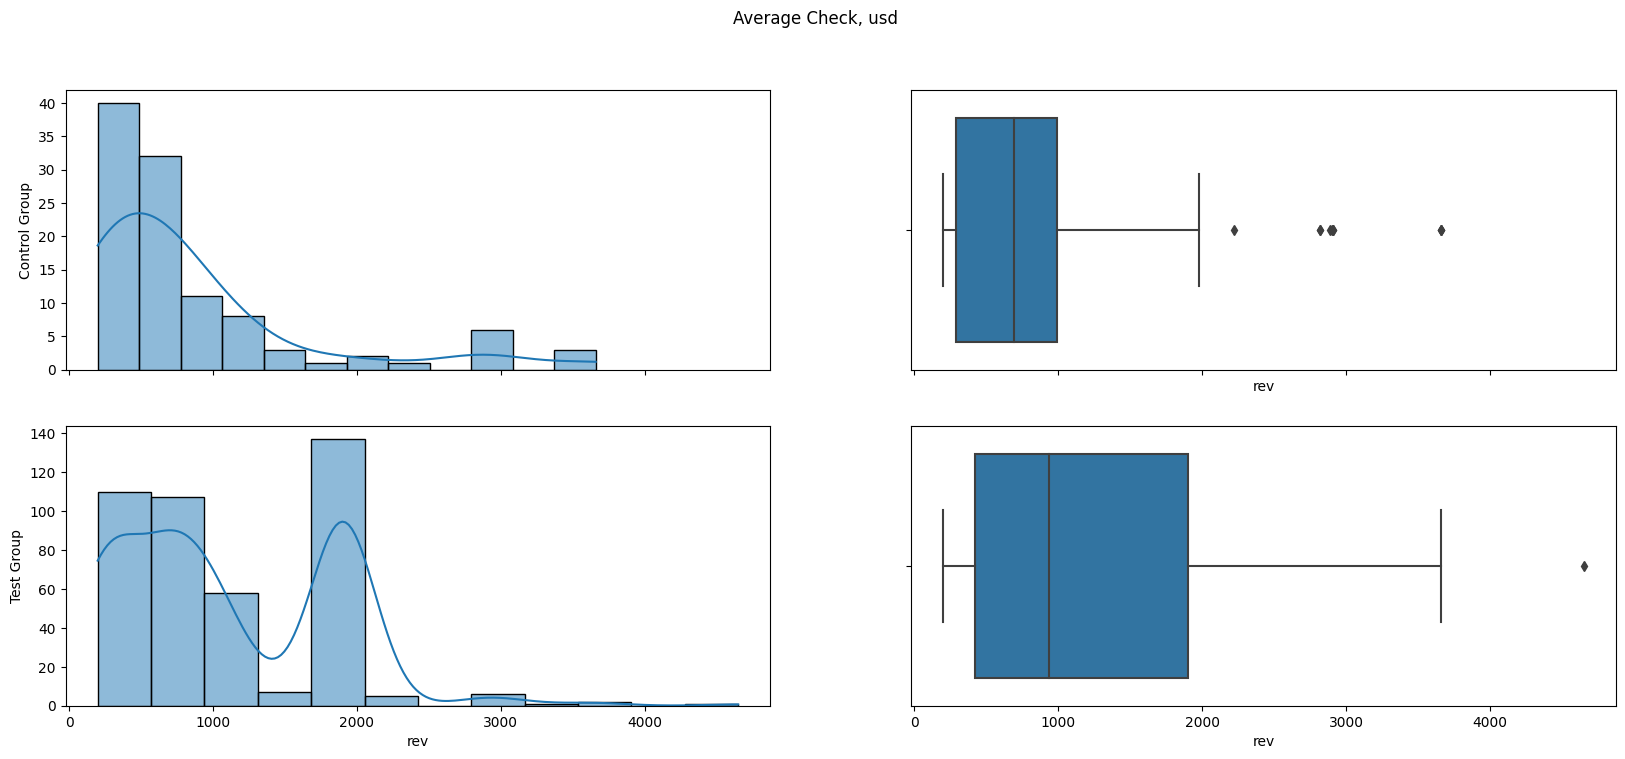

In [6]:
vis_metrics(results, 'avg_check')

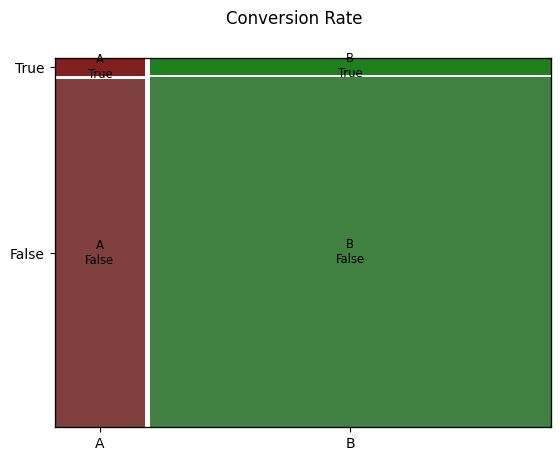

In [7]:
vis_metrics(results, 'conv_rate')